<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
train_df = pd.read_csv("./dataset/train-balanced-sarcasm.csv")

In [3]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [5]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [6]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [7]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example

Distribution of lengths for sarcastic and normal comments 

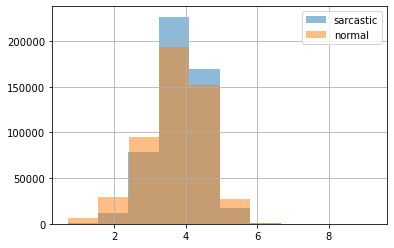

In [8]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [9]:
stopwords = []
for word in STOPWORDS:
    for splited in word.split("'"):
        stopwords.append(splited)

In [10]:
def get_most_frequent_words(data, n, amount):
    cv = TfidfVectorizer(analyzer='word', stop_words=stopwords, ngram_range=(n, n))
    cv.fit(data)
    wl = cv.transform(data).sum(axis=0).A[0,:]
    n_grams_list = []
    
    for item in cv.vocabulary_.items():
        n_grams_list.append([item[0], wl[item[1]]])    
    n_grams_list.sort(key=lambda x: x[1], reverse=True)
    
    return pd.DataFrame(data=sorted(n_grams_list[:amount], key=lambda x: x[1]), columns=['Words', 'Amount'])

Top 10 most 3 frequent words for sarcastic comments

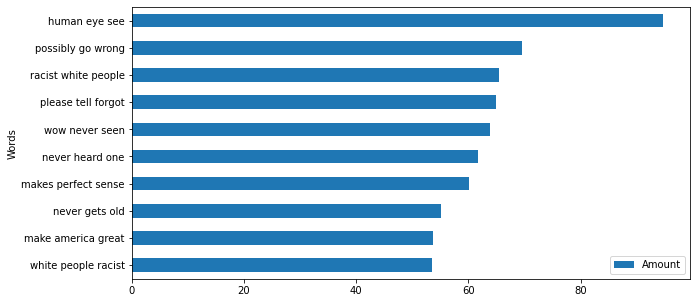

In [11]:
get_most_frequent_words(train_df[train_df["label"] == 1]["comment"], 3, 10).plot(kind='barh', x='Words', figsize=(10,5));

Top 10 most 3 frequent words for normal comments

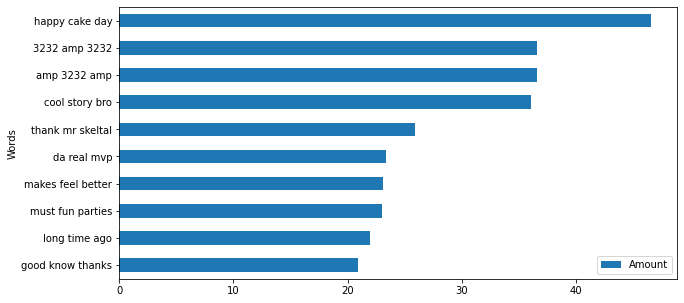

In [12]:
get_most_frequent_words(train_df[train_df["label"] == 0]["comment"], 3, 10).plot(kind='barh', x='Words', figsize=(10,5));

Wordcloud for sarcastic comments

In [13]:
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      max_words=300,
                      background_color='white',
                      max_font_size = 50,
                      collocations=False,
                      width=300, 
                      height=300)

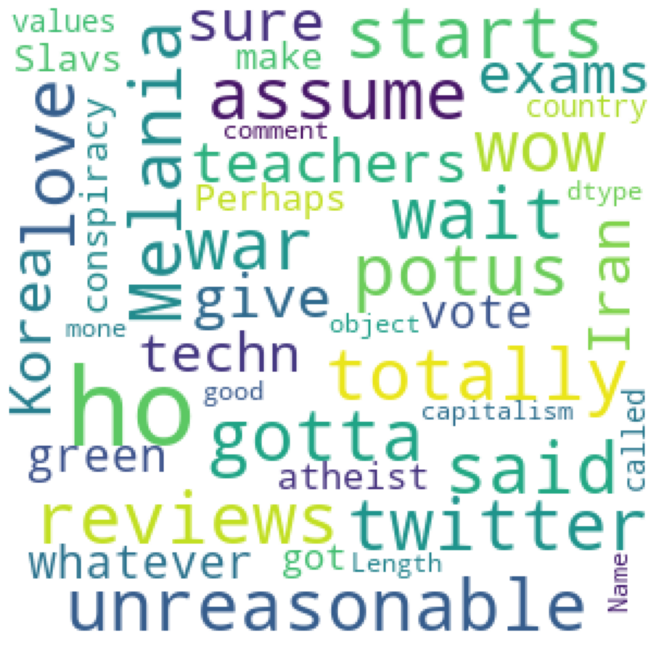

In [14]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df[train_df['label'] == 1]['comment']))
plt.axis("off")
plt.imshow(wordcloud);

Wordcloud for normal comments

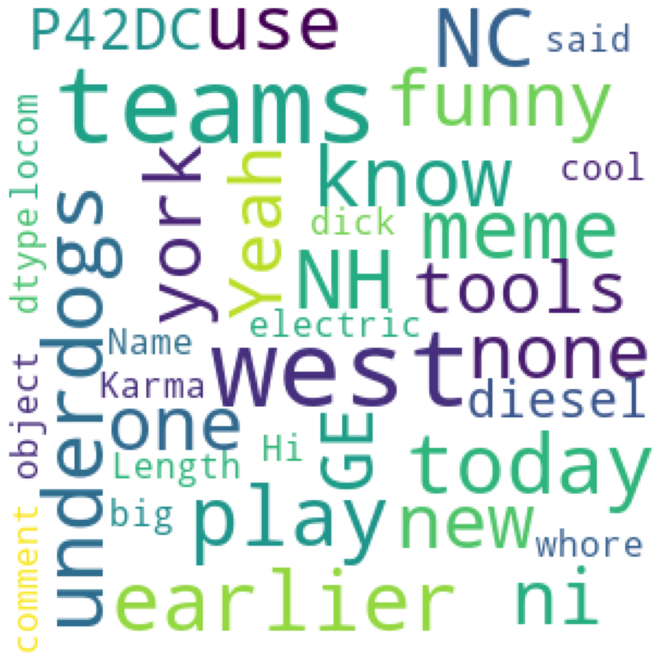

In [15]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df[train_df['label'] == 0]['comment']))
plt.axis("off")
plt.imshow(wordcloud);

2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).


In [16]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [17]:
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.5s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [18]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

In [19]:
accuracy_score(y_valid, valid_pred)

0.7208956287050742

3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)

In [20]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

C:\Users\Iulia\Anaconda3\envs\BigData\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Iulia\Anaconda3\envs\BigData\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight?,Feature
+9.483,yes because
+7.712,clearly
+7.300,yeah because
+7.232,obviously
+6.707,totally
+6.567,because
+5.916,how dare
+5.796,right because
+5.443,but thought
+5.254,duh


4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

In [21]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [22]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [23]:
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

In [24]:
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [25]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [26]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.1s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [27]:
valid_pred = logit.predict(X_valid)

In [28]:
accuracy_score(y_valid, valid_pred)

0.7237726261802813